## Ensemble Exploration
Questions to find answers to:
- What is a good workflow for passing one image through the ensemble
- What is a suitable loss? (Data is needed for that.)
- Deep mutual learning losses vs standard student teacher loss

In [82]:
import torch
import torch.nn.functional as F

import numpy as np
import cv2
from math import ceil
import matplotlib.pyplot as plt

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet
from utils.plotting import flow2img
from utils.layers import warp


from models.pdd_net.pdd_student import OBELISK2d, deeds2d

In [2]:
flow2 = load_flownet2().cuda()
pwc = load_pwcnet().cuda()

/home/till/uni/MasterThesis/models/pwc_net/models/PWCNet.py:142: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_in')


In [11]:
net = OBELISK2d()
reg = deeds2d()

PWC and Flow2 seem to occupy around 1,5 GB on a graphics card

In [3]:
imgs = torch.load('Data/img.pth')
segs = torch.load('Data/seg.pth')

fix = 12; mov=9
fixed = imgs[fix:fix+1,:,:].float() /255
moving = imgs[mov:mov+1,:,:].float() /255

fixed_seg = segs[fix:fix+1, :,:].long().contiguous()
moving_seg = segs[mov:mov+1,:,:].long().contiguous()

C,h,w = fixed.shape

In [4]:
flow_in = preprocessing_flownet(fixed.reshape(h,w,C),moving.reshape(h,w,C)).cuda()

In [5]:
flow_in.shape

torch.Size([1, 3, 2, 320, 256])

In [6]:
flow2_out = flow2(flow_in).cpu()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [7]:
pwc_in = preprocessing_pwc(fixed.reshape(h,w,C),moving.reshape(h,w,C))

In [8]:
pwc.eval()
pwc_out = pwc(pwc_in.cuda())
pwc_out = pwc_out[0]*20
pwc_out = pwc_out.cpu().data.numpy()

pwc_out = np.swapaxes(np.swapaxes(pwc_out, 0, 1), 1, 2) 

divisor = 64
H_ = int(ceil(h/divisor) * divisor)
W_ = int(ceil(w/divisor) * divisor)

u_ = cv2.resize(pwc_out[:,:,0],(w,h))
v_ = cv2.resize(pwc_out[:,:,1],(w,h))
u_ *= w/ float(W_)
v_ *= h/ float(H_)
pwc_out = np.dstack((u_,v_))

pwc_out.shape

torch.Size([1, 81, 5, 4])


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(320, 256, 2)

In [9]:
flow2_out = flow2_out.squeeze().cpu().detach().numpy().transpose(1,2,0)
flow2_out.shape

(320, 256, 2)

In [12]:
feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)

In [13]:
grid_size = 32#25#30

pdd_out = cv2.resize(pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(w,h))
pdd_out.shape

(320, 256, 2)

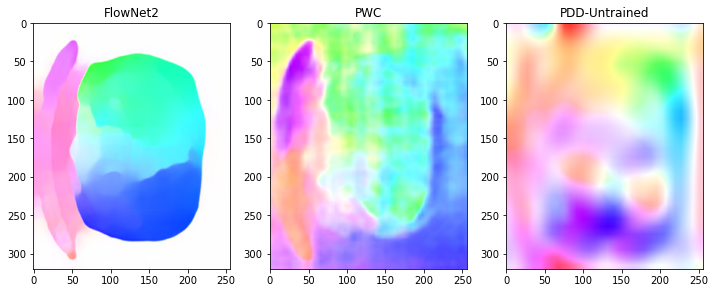

In [14]:
fig = plt.figure(figsize=(12,12))
plt.subplot(131)
plt.title("FlowNet2")
plt.imshow(flow2img(flow2_out))

plt.subplot(132)
plt.title("PWC")
plt.imshow(flow2img(pwc_out))

plt.subplot(133)
plt.title("PDD-Untrained")
plt.imshow(flow2img(pdd_out))

So not happy with PWC

### Losses
There are some ways in which the loss can be computet.
- grid_sample the flow of the teacher and calculate the loss for the pdd
- upscale pdd output, calculate loss and downscale the loss, to fit the reg output

In [166]:
def grid_sample_teacher(pdd_output, teacher_output, grid_xy):
    teacher_grid = F.grid_sample((teacher_output).unsqueeze(0).reshape(1,2,h,w), grid_xy, align_corners=True).view(-1,2)
    
    diff = torch.pow((teacher_grid - pdd_output),2)
    return diff

def upscale_pdd(pdd_output, teacher_output):
    
    #Upscale pdd_output
    #pdd_output.resize(w,h,2)
    up = torch.nn.Upsample(size=(h,w), mode='bilinear', align_corners=True)

    upscaled = up(pdd_output.reshape(1,2,32,32))
    diff = torch.pow((teacher_output-upscaled),2)
    #diff_grid = F.grid_sample(torch.from_numpy(diff).unsqueeze(0).reshape(1,2,h,w), grid_xy, align_corners=True).view(-1,2)
    
    return diff

### Let's get a small pdd_net to learn FlowNet2 output

In [69]:
net = OBELISK2d()
reg = deeds2d()

epochs = 1000
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.0005)

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,grid_size,grid_size,2)

trying to overfit on the flow of the flownet2. Using an upscaled version of the pred_xy output of pddNet to calculate the error

In [70]:
# Testing with only one image to overfit on the flow and check if it works
# verfitting with upscale
diffs = []
for i in range(epochs):
    optimizer.zero_grad()
    
    # Genrate the flow we want to approximate
    teacher_output = flow2(flow_in).cpu()
    
    # Generate the pdd-output
    fixed.requires_grad = True
    moving.requires_grad=True
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    cost_soft, pred_xy = reg(feat00,feat50)
    diff = upscale_pdd(pred_xy, teacher_output).mean()
    diff.backward()
    diffs.append(diff.item())
    optimizer.step()
    
    if (i%50 == 49):
        print(diff.mean())

tensor(54.8423, grad_fn=<MeanBackward0>)
tensor(54.3534, grad_fn=<MeanBackward0>)
tensor(53.9899, grad_fn=<MeanBackward0>)
tensor(53.8123, grad_fn=<MeanBackward0>)
tensor(53.7251, grad_fn=<MeanBackward0>)
tensor(53.7069, grad_fn=<MeanBackward0>)
tensor(53.6523, grad_fn=<MeanBackward0>)
tensor(53.6355, grad_fn=<MeanBackward0>)
tensor(53.6249, grad_fn=<MeanBackward0>)
tensor(53.6176, grad_fn=<MeanBackward0>)
tensor(53.6120, grad_fn=<MeanBackward0>)
tensor(53.6077, grad_fn=<MeanBackward0>)
tensor(53.7255, grad_fn=<MeanBackward0>)
tensor(53.6152, grad_fn=<MeanBackward0>)
tensor(53.6076, grad_fn=<MeanBackward0>)
tensor(53.6039, grad_fn=<MeanBackward0>)
tensor(53.6015, grad_fn=<MeanBackward0>)
tensor(53.5998, grad_fn=<MeanBackward0>)
tensor(53.5985, grad_fn=<MeanBackward0>)
tensor(53.5973, grad_fn=<MeanBackward0>)


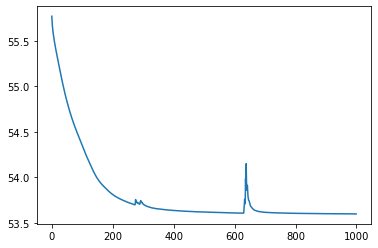

In [71]:
plt.plot(np.arange(epochs), diffs)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


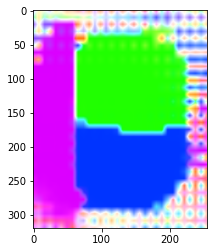

In [72]:
feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)
pdd_out = up(pred_xy.view(1,2,32,32)).squeeze().detach().numpy().transpose(1,2,0)
#cv2.resize(pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(h,w))
plt.imshow(flow2img(pdd_out))

Overfitted one flow from flownet with upscaling the output of the pddnet and calculaitng the loss 

### Training on the flow output
Trying to overfit on the flow output of flownet2. Using the grid sampled flow of the teacher for error calculations

In [167]:
net = OBELISK2d()
reg = deeds2d()

epochs = 1000
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.0005)

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,grid_size,grid_size,2)

In [168]:
# Testing with only one image to overfit on the flow and check if it works
# overfitting with grid_sampling
diffs = []
for i in range(epochs):
    optimizer.zero_grad()
    
    # Genrate the flow we want to approximate
    teacher_output = flow2(flow_in).cpu()
    
    # Generate the pdd-output
    fixed.requires_grad = True
    moving.requires_grad=True
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    cost_soft, pred_xy = reg(feat00,feat50)
    diff = grid_sample_teacher(pred_xy, teacher_output, grid_xy).mean()
    diff.backward()
    diffs.append(diff.item())
    optimizer.step()
    
    if (i%50 == 49):
        print(diff.mean())

tensor(54.6580, grad_fn=<MeanBackward0>)
tensor(54.1325, grad_fn=<MeanBackward0>)
tensor(53.8043, grad_fn=<MeanBackward0>)
tensor(53.6305, grad_fn=<MeanBackward0>)
tensor(53.5431, grad_fn=<MeanBackward0>)
tensor(53.4854, grad_fn=<MeanBackward0>)
tensor(53.4562, grad_fn=<MeanBackward0>)
tensor(53.4856, grad_fn=<MeanBackward0>)
tensor(53.4265, grad_fn=<MeanBackward0>)
tensor(53.4154, grad_fn=<MeanBackward0>)
tensor(53.4078, grad_fn=<MeanBackward0>)
tensor(53.4020, grad_fn=<MeanBackward0>)
tensor(53.3974, grad_fn=<MeanBackward0>)
tensor(53.3937, grad_fn=<MeanBackward0>)
tensor(53.3907, grad_fn=<MeanBackward0>)
tensor(53.3880, grad_fn=<MeanBackward0>)
tensor(53.3856, grad_fn=<MeanBackward0>)
tensor(53.3830, grad_fn=<MeanBackward0>)
tensor(53.4180, grad_fn=<MeanBackward0>)
tensor(53.3952, grad_fn=<MeanBackward0>)


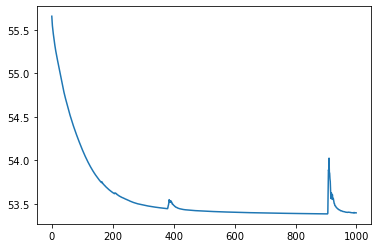

In [169]:
plt.plot(np.arange(epochs), diffs)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


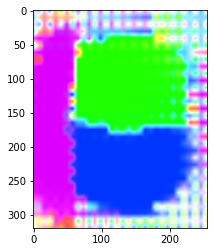

In [170]:
feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)
pdd_out = up(pred_xy.view(1,2,32,32)).squeeze().detach().numpy().transpose(1,2,0)
#cv2.resize(pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(h,w))
plt.imshow(flow2img(pdd_out))

### Train Pdd with Flow2 as teacher

In [138]:
net = OBELISK2d()
reg = deeds2d()

epochs = 1000
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.00025)

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2) #.view(1,grid_size,grid_size,2)
disp_range = 0.25#0.25
displacement_width = 11#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [156]:
diffs = []
for i in range(epochs):
    optimizer.zero_grad()
    
    # Genrate the flow we want to approximate
    teacher_output = flow2(flow_in).cpu()
    
    # Generate the pdd-output
    fixed.requires_grad = True
    moving.requires_grad=True
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    cost_soft, pred_xy = reg(feat00,feat50)
    
    #warp moving seg to fixed seg with teacher
    teacher_warped = warp(moving_seg.unsqueeze(0).cuda().float(), teacher_output.cuda()).cpu().to(torch.int64)
    
    #diff = grid_sample_teacher(pred_xy, teacher_output, grid_xy).mean()
    
    # Not sure what this does. 
    nonlocal_label = (F.grid_sample(moving_seg.float().unsqueeze(0),grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(fixed_seg.float().unsqueeze(0),grid_xy,padding_mode='border')#.long().squeeze(1)

    orig_labelloss = ((nonlocal_label-fixed_label)**2) #*class_weight.view(1,-1,1,1)
    
    teacher_label = (F.grid_sample(teacher_warped.float(),grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    
    teacher_loss = (nonlocal_label - teacher_label)**2
    
    loss = (1/2 * orig_labelloss + (1/2 * teacher_loss)).mean()
    teacher_loss.mean().backward()
    diffs.append(teacher_loss.mean().item())
    
    #diff.backward()
    #diffs.append(diff.item())
    optimizer.step()
    
    if (i%50 == 49):
        print(loss)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(0.9224, grad_fn=<MeanBackward0>)
tensor(0.9225, grad_fn=<MeanBackward0>)
tensor(0.9226, grad_fn=<MeanBackward0>)
tensor(0.9226, grad_fn=<MeanBackward0>)
tensor(0.9226, grad_fn=<MeanBackward0>)
tensor(0.9227, grad_fn=<MeanBackward0>)
tensor(0.9227, grad_fn=<MeanBackward0>)
tensor(0.9227, grad_fn=<MeanBackward0>)
tensor(0.9227, grad_fn=<MeanBackward0>)
tensor(0.9228, grad_fn=<MeanBackward0>)
tensor(0.9228, grad_fn=<MeanBackward0>)
tensor(0.9228, grad_fn=<MeanBackward0>)
tensor(0.9228, grad_fn=<MeanBackward0>)
tensor(0.9229, grad_fn=<MeanBackward0>)
tensor(0.9229, grad_fn=<MeanBackward0>)
tensor(0.9229, grad_fn=<MeanBackward0>)
tensor(0.9230, grad_fn=<MeanBackward0>)
tensor(0.9231, grad_fn=<MeanBackward0>)
tensor(0.9232, grad_fn=<MeanBackward0>)
tensor(0.9232, grad_fn=<MeanBackward0>)


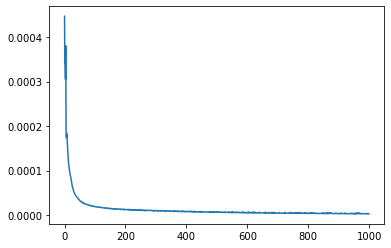

In [157]:
plt.plot(np.arange(epochs), diffs)

In [158]:
feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [159]:
grid_size = 32#25#30

pdd_out = cv2.resize(pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(w,h))


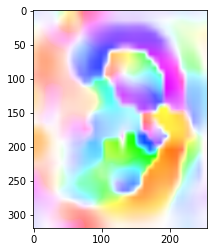

In [160]:
plt.imshow(flow2img(pdd_out))

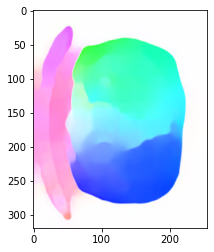

In [161]:
plt.imshow(flow2img(teacher_output.squeeze().detach().numpy().transpose(1,2,0)))